In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
path = Path("/mnt/nas/backups/08-07-2020/desktopg01/lisa/Data/small_flow")

In [4]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=GrandparentSplitter(valid_name="val"),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75,
                                               do_flip=False, max_rotate=0,
                                               max_warp=0
                                               ),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [5]:
dls = get_dls(64, 224)

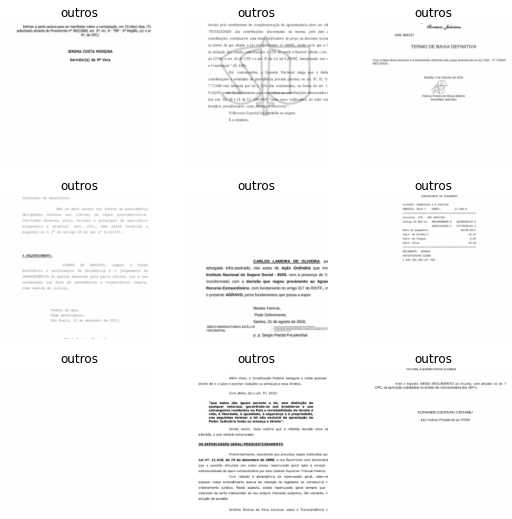

In [6]:
dls.show_batch()

In [7]:
fscore = F1Score(average='macro')

In [15]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, fscore])

In [12]:
learn.freeze()

In [ ]:
learn.summary()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.03981071710586548)

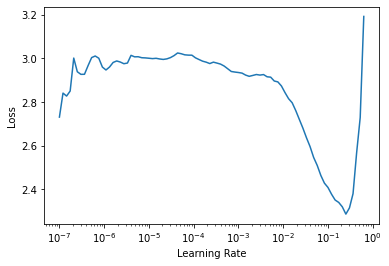

In [11]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In [14]:
learn.save("resnet50-fine-tuned-1E-224")

Path('models/resnet50-fine-tuned-1E-224.pth')

In [16]:
learn.load("resnet50-fine-tuned-1E-224")

In [17]:
preds, targets = learn.get_preds()

In [24]:
preds = np.argmax(preds, axis=1); preds.shape

torch.Size([102997])

In [28]:
from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       314
agravo_em_recurso_extraordinario     1.0000    0.0004    0.0008      2650
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       183
                          outros     0.8884    0.9999    0.9408     91434
                   peticao_do_RE     0.0000    0.0000    0.0000      6803
                        sentenca     0.9506    0.0477    0.0909      1613

                        accuracy                         0.8884    102997
                       macro avg     0.4732    0.1747    0.1721    102997
                    weighted avg     0.8293    0.8884    0.8367    102997



/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
_________________________________________________

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=5.754399353463668e-06)

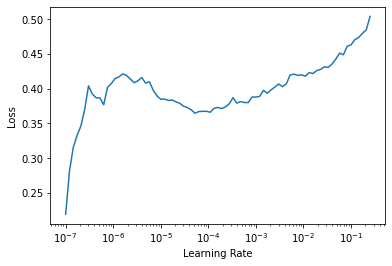

In [16]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(3, lr_max=slice(2e-6,2e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.376510,0.398590,0.888948,0.888948,2:55:02
1,0.348020,0.373706,0.889346,0.889346,2:56:31
2,0.336506,0.391261,0.891278,0.891278,2:56:27


In [19]:
learn.save("resnet50-fine-tuned-1E-disc-3E-224")

Path('models/resnet50-fine-tuned-1E-disc-3E-224.pth')

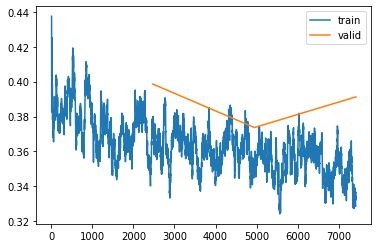

In [21]:
learn.recorder.plot_loss()

In [22]:
preds, targets = learn.get_preds()

In [23]:
preds = np.argmax(preds, axis=1); preds.shape

torch.Size([102997])

In [24]:
from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       314
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      2650
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       183
                          outros     0.8918    0.9990    0.9423     91434
                   peticao_do_RE     0.7820    0.0548    0.1025      6803
                        sentenca     0.9540    0.0515    0.0976      1613

                        accuracy                         0.8913    102997
                       macro avg     0.4380    0.1842    0.1904    102997
                    weighted avg     0.8582    0.8913    0.8448    102997



/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
preds, targets = learn.get_preds(0)

In [26]:
preds = np.argmax(preds, axis=1); preds.shape

torch.Size([158308])

In [27]:
from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       583
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      4220
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       361
                          outros     0.8992    0.9968    0.9455    140786
                   peticao_do_RE     0.8277    0.1137    0.2000     10181
                        sentenca     0.7186    0.2627    0.3848      2177

                        accuracy                         0.8974    158308
                       macro avg     0.4076    0.2289    0.2550    158308
                    weighted avg     0.8628    0.8974    0.8590    158308



In [10]:
n_samples = len(dls.train_ds); n_samples

158308

In [12]:
n_classes = dls.c; n_classes

6

In [ ]:
y = [x[1] for x in dls.train_ds]; y

In [ ]:
class_weights = n_samples / (n_classes * np.bincount(y)); class_weights

In [ ]:
class_weights = 1 - np.bincount(y)/n_samples; class_weights

In [ ]:
class_weights = torch.FloatTensor(class_weights).cuda()

In [ ]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(weight=class_weights), metrics=[accuracy, fscore])

In [ ]:
learn.freeze()

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In [14]:
learn.save("resnet50-fine-tuned-1E-224_class_weights")

Path('models/resnet50-fine-tuned-1E-224.pth')

In [16]:
learn.load("resnet50-fine-tuned-1E-224_class_weights")

In [17]:
preds, targets = learn.get_preds()

In [24]:
preds = np.argmax(preds, axis=1); preds.shape

torch.Size([102997])

In [28]:
from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       314
agravo_em_recurso_extraordinario     1.0000    0.0004    0.0008      2650
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       183
                          outros     0.8884    0.9999    0.9408     91434
                   peticao_do_RE     0.0000    0.0000    0.0000      6803
                        sentenca     0.9506    0.0477    0.0909      1613

                        accuracy                         0.8884    102997
                       macro avg     0.4732    0.1747    0.1721    102997
                    weighted avg     0.8293    0.8884    0.8367    102997



/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 64 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               64 x 64 x 56 x 56    36,864     True      
_________________________________________________

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=5.754399353463668e-06)

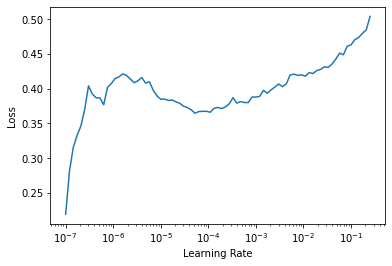

In [16]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(3, lr_max=slice(2e-6,2e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.376510,0.398590,0.888948,0.888948,2:55:02
1,0.348020,0.373706,0.889346,0.889346,2:56:31
2,0.336506,0.391261,0.891278,0.891278,2:56:27


In [19]:
learn.save("resnet50-fine-tuned-1E-disc-3E-224_class_weights")

Path('models/resnet50-fine-tuned-1E-disc-3E-224.pth')

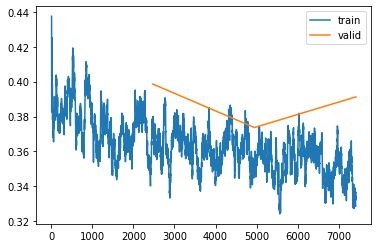

In [21]:
learn.recorder.plot_loss()

In [22]:
preds, targets = learn.get_preds()

In [23]:
preds = np.argmax(preds, axis=1); preds.shape

torch.Size([102997])

In [24]:
from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       314
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      2650
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       183
                          outros     0.8918    0.9990    0.9423     91434
                   peticao_do_RE     0.7820    0.0548    0.1025      6803
                        sentenca     0.9540    0.0515    0.0976      1613

                        accuracy                         0.8913    102997
                       macro avg     0.4380    0.1842    0.1904    102997
                    weighted avg     0.8582    0.8913    0.8448    102997



/mnt/home/peluz/victor-visual-text/fastai2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
preds, targets = learn.get_preds(0)

In [26]:
preds = np.argmax(preds, axis=1); preds.shape

torch.Size([158308])

In [27]:
from sklearn.metrics import classification_report

print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       583
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      4220
     despacho_de_admissibilidade     0.0000    0.0000    0.0000       361
                          outros     0.8992    0.9968    0.9455    140786
                   peticao_do_RE     0.8277    0.1137    0.2000     10181
                        sentenca     0.7186    0.2627    0.3848      2177

                        accuracy                         0.8974    158308
                       macro avg     0.4076    0.2289    0.2550    158308
                    weighted avg     0.8628    0.8974    0.8590    158308

